In [1]:
import xarray as xr
import matplotlib.pyplot as plt

from src import data_catalog
from src import tseries_mod
from src.utils import repl_coord
from src.utils_plot import plot_1var
from src.utils_units import conv_units
from src.config import forcing_dir

%matplotlib inline

In [2]:
data_catalog.set_catalog('cesm_coupled')

active catalog: cesm_coupled


In [3]:
varnames = ['CO2', 'SFCO2_LND', 'SFCO2_OCN', 'SFCO2_FFF']

In [4]:
path_obs = '/'.join([forcing_dir, 'LBC_1750-2015_CMIP6_GlobAnnAvg_c180926.nc'])
ds_obs_time_slice = xr.open_dataset(path_obs).sel(time=slice('1850-01-01', '2015-01-01'))

# store copy of time:bounds, because xarray drops it when averaging over 'lat'
tb_name = ds_obs_time_slice.time.attrs['bounds']
tb = ds_obs_time_slice[tb_name]

ds_obs = ds_obs_time_slice.mean('lat')
ds_obs[tb_name] = tb

ds_obs['CO2_LBC'] = conv_units(ds_obs['CO2_LBC'], 'ppmv')

In [5]:
def gen_ds_ann(experiment, legend, stream='cam.h0'):
    ds_ann = tseries_mod.tseries_get_vars(varnames, 'atm', experiment, stream=stream, freq='ann')
    ds_ann.attrs['legend'] = legend

    # add cummulate flux vars
    for varname in ['SFCO2_LND', 'SFCO2_OCN', 'SFCO2_FFF']:
        da = ds_ann[varname].cumsum(dim='time', keep_attrs=True)
        da.attrs['units'] = 'Pg'
        ds_ann[varname+'_CUM'] = da

    # add CO2_obs and CO2_bias
    ds_obs_repl_time = repl_coord('time', ds_ann, ds_obs.isel(time=slice(0, ds_ann.dims['time'])))
    ds_ann['CO2_obs'] = ds_obs_repl_time['CO2_LBC']

    ds_ann['CO2_bias'] = ds_ann['CO2'] - ds_ann['CO2_obs']

    return ds_ann

In [6]:
ds_dict = {}

experiment = 'esm-hist'
ds_dict[experiment] = gen_ds_ann(experiment, 'esm-hist CESM2')

experiment = 'esm-hist-cmip5'
ds_dict[experiment] = gen_ds_ann(experiment, 'esm-hist CESM1(BGC)', 'cam2.h0')

experiment = 'historical'
ds_dict[experiment] = gen_ds_ann(experiment, 'historical CESM2')

experiment = 'historical-cmip5'
ds_dict[experiment] = gen_ds_ann(experiment, 'historical CESM1(BGC)', 'cam2.h0')

In [7]:
expr_list = ['esm-hist-cmip5', 'esm-hist']
ds_list = [ds_dict[expr] for expr in expr_list]
legend_list = [ds.attrs['legend'] for ds in ds_list]

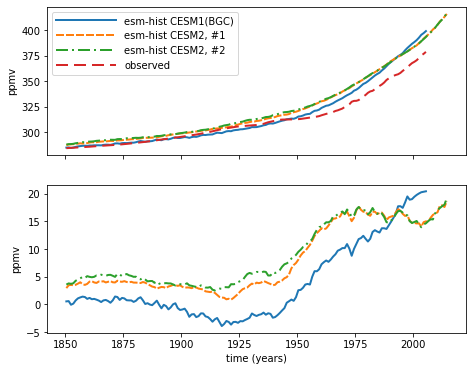

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7.5,6))

linestyle_list = [
    'solid',
    (0, (4, 1)),
    (0, (6, 2, 1, 2)),
    (0, (6, 3)),
    (0, (6, 6)),
    (0, (6, 2, 1, 2, 1, 2)),
    (0, (6, 6)),
]

plot_1var('CO2', ds_list, legend_list, region_val='Global', vdim_name='lev', ax=ax[0],
          linewidth=2.0, linestyle_list=linestyle_list, handlelength=6.0, show_xlabel=False)
plot_1var('CO2_obs', ds_list[0:1], ['observed'], ax=ax[0],
          linewidth=2.0, linestyle_list=linestyle_list[3:], handlelength=6.0, show_xlabel=False)

plot_1var('CO2_bias', ds_list, legend_list, region_val='Global', vdim_name='lev', ax=ax[1],
          linewidth=2.0, linestyle_list=linestyle_list, handlelength=6.0, show_legend=False,
          fname='CO2_BOT_esm-hist.pdf');

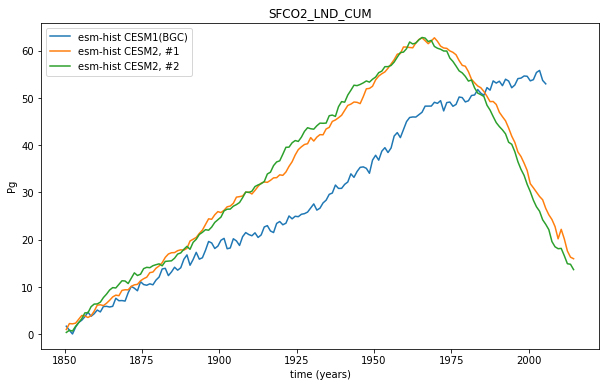

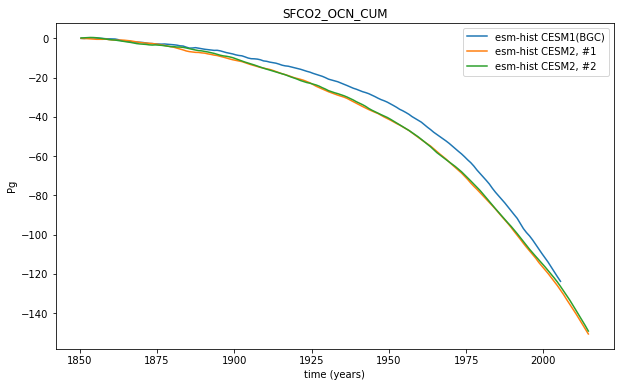

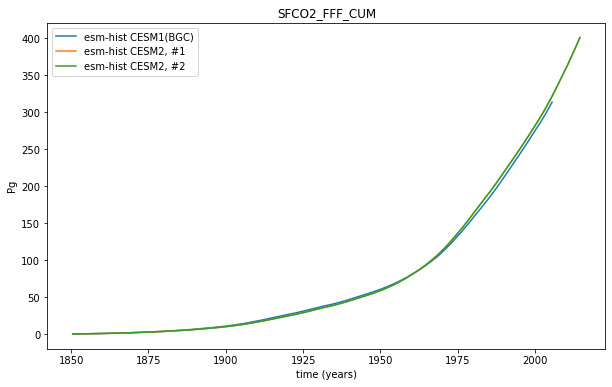

In [9]:
for varname in ['SFCO2_LND_CUM', 'SFCO2_OCN_CUM', 'SFCO2_FFF_CUM']:
    plot_1var(varname, ds_list, legend_list, title=varname, region_val='Global')

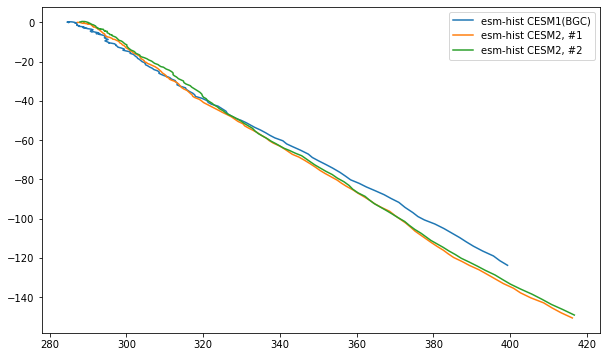

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
for ds_ind, ds in enumerate(ds_list):
    ds_glo = ds.sel(region='Global')
    if 'ensemble' in ds_glo.dims:
        for ensemble in range(ds.dims['ensemble']):
            ax.plot(ds_glo['CO2'].isel(lev=-1).sel(ensemble=ensemble), ds_glo['SFCO2_OCN_CUM'].sel(ensemble=ensemble),
                    label=f'{legend_list[ds_ind]}, #{ensemble+1}')
    else:
        ax.plot(ds_glo['CO2'].isel(lev=-1), ds_glo['SFCO2_OCN_CUM'], label=legend_list[ds_ind])
ax.legend();

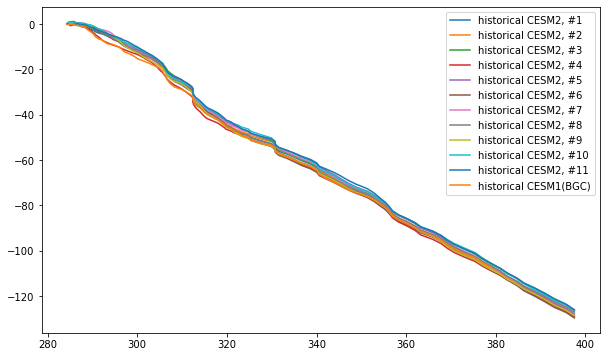

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
expr_list = ['historical', 'historical-cmip5']
ds_list = [ds_dict[expr] for expr in expr_list]
legend_list = [ds.attrs['legend'] for ds in ds_list]
for ds_ind, ds in enumerate(ds_list):
    ds_glo = ds.sel(region='Global')
    if 'ensemble' in ds_glo.dims:
        for ensemble in range(ds.dims['ensemble']):
            ax.plot(ds_glo['CO2_obs'], ds_glo['SFCO2_OCN_CUM'].sel(ensemble=ensemble),
                    label=f'{legend_list[ds_ind]}, #{ensemble+1}')
    else:
        ax.plot(ds_glo['CO2_obs'], ds_glo['SFCO2_OCN_CUM'], label=legend_list[ds_ind])
ax.legend();